# Deep Learning With PyTorch
**Deep Learning** is a subset of *Machine Learning* where the fundemental structure is a network of inputs, ($\geq 1$) hidden layers, and outputs. The original intuition of deep learning was modelling how the human brain learns; through inter-connected neurons. One of the most popular deep learning frameworks is ***Pytorch*** ,`torch`, sharing similarities with the `numpy` library (instead uses tensors `torch.tensor([[1, 2, 3], [4, 5, 6]])` instead of arrays/matrices).
- Element-wise operations ($X_{a\times b}\cdot Y_{a\times b}$):`x + y` (addition), `x - y` (subtraction), `x * y` (multiplication), `torch.div(x,y)` (division)
- Matrix operations ($X_{a\times b}\cdot Y_{b\times c}$): `x @ y` (multiplication), `torch.linalg.inv(x)` (matrix inverse)

## Neural Network (NN)
### OOP deep learning model

In [97]:
import torch.nn as nn
import torch.nn.init as init

# OOP model to replace:
# net = nn.Sequential(nn.Linear(9,16), 
#               nn.ReLU(), 
#               nn.Linear(16,8), 
#               nn.ReLU(), 
#               nn.Linear(8,1), 
#               nn.Sigmoid())

class Net(nn.Module):
    def __init__(self): # network definition
        super().__init__()
        self.fc1 = nn.Linear(9,16)
        self.fc2 = nn.Linear(16,8)
        self.fc3 = nn.Linear(8,1)

    def forward(self, x): # forward pass
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.sigmoid(self.fc3(x))
        return x

net = Net()


## solutions for unstable (vanishing/exploding) gradients:
class Net2(Net):
    # Batch normalization: (normalize the layers' outputs, scale and shift normalized outputs using learned parameters)
    # - model learns optimal inputs distribution for each layer
    #   - faster loss decrease
    #   - helps against unstable gradients
    def __init__(self):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(16)
        self.bn2 = nn.BatchNorm1d(8)
        self._weight_initialization()

    # Proper weight initialization: (dependent on activation function)
    # - ensures variance of layer inputs = variance of layer outputs
    # - ensures variance of gradients is the same before and after a layer
    def _weight_initialization(self):
        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)
        init.kaiming_uniform_(self.fc3.weight, nonlinearity="sigmoid")

    # Activation functions with non-zero gradients for negative values:(ELU, etc.)
    # - help against dying neurons (become 0 and never change after)
    # - average output > 0 and thereby help against vanishing gradients
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.elu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.functional.elu(x)
        # = nn.functional.leaky_relu(x, negative_slope=0.05) # ReLU where slope for x < 0 is != 0
        x = self.fc3(x)
        x = nn.functional.sigmoid(x)
        return x

### DataLoader setup

In [ ]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class CsvDataset(Dataset):
    def __init__(self, csv_path):
        super().__init__()
        df = pd.read_csv(csv_path)
        self.data = df.to_numpy()

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, indx):
        features = self.data[indx, :-1]
        label = self.data[indx, -1]
        return features, label
    
train_dataset = CsvDataset('train.csv')
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

### Model Training

In [ ]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.95) # stochastic gradient descent
#         = optim.Adagrad(net.parameters(), lr=0.01) # adaptive gradient descent (different learning rate for each parameter)
#         = optim.RMSprop(net.parameters(), lr=0.01) # root mean square propagation (update for each parameter based on the size of previous gradient)
#         = optim.Adam(net.parameters(), lr=0.01) # adaptive moment estimation (RMSprop + gradient momentum)

for epoch in range(1000):
    for features, label in train_dataloader:
        optimizer.zero_grad()
        outputs = net(features)
        loss = criterion(outputs, label.view(-1,1))
        loss.backward()
        optimizer.step()

### Evaluation Procedure

In [ ]:
import torch
from torchmetrics import Accuracy

test_dataset = CsvDataset('test.csv')
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)

acc = Accuracy(task="binary")

net.eval()
with torch.no_grad():
    for features, label in test_dataloader:
        outputs = net(features)
        pred = (outputs >= 0.5).float()
        acc(pred, label.view(-1,1))

accuracy = acc.compute()
print(f"accuracy: {accuracy}")

In multi-class classification, seperate precision (fraction of cumulus-prediction that were correct) and recall (fraction of all cumulus examples correctly predicted) exist for each class. These then can be analysed by aggregating the scores; globally (micro average), per class (macro average), weighted mean per class (weighted average).

In [ ]:
from torchmetrics import Precision, Recall

precision = Precision(task="multiclass", num_classes=7, average="macro")
recall = Recall(task="multiclass", num_classes=7, average="weighted")
# ...
{k: recall[v].item() for k,v in test_dataset.class_to_idx.items()}

## Convolutional NN

### Data Augmentation

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Generating more data by applying random transformations to the original images
# - increase size and diversity of training set
# - improve model robustness
# - reduces overfitting
# Note that transformation need to be logical to the data and task (i.e. if designed to detect lemons vs. limes, 
# cannot alter the color as label would not be accurate anymore)
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    # ...
    transforms.ToTensor(),
    transforms.Resize((64,64))
])
train_dataset = ImageFolder("./train", transform=train_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
image, label = next(iter(train_dataloader))
image = image.squeeze().permute(1, 2, 0) # alter dimensions of image to correctly display it

# Note that there should be no data augmentation for test data

### Convolutional Layers

In [ ]:
## Normal Convolutional Layers
# Slide overlapping filter(s) of parameters over the input, performing convolution (dot-product) at each position resulting in a feature map (one 
# filter = one feature map); preserving spatial patters from input, and uses fewer parameters than linear layers. Activation functions are then 
# applied to each feature map (similar to normal NN), and all maps are combined to form an output.
# - a frame of 0s can be added to convolutional layer's input to ensure border pixels are treated equally to others.

## MaxPooling
# Slide non-overlapping window(s) over the input, and at each position retaining only the maximum value (used after convolutional layers to reduce 
# spatial dimensions).

class Net(nn.Module):
    def __init__(self, num_classes): # network definition
        super().__init__()
        self.cl1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.cl2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.cl3 = nn.MaxPool2d(kernel_size=2)
        self.cl4 = nn.Flatten()

        self.fc1 = nn.Linear(16*16*64,num_classes)

    def forward(self, x): # forward pass
        x = self.cl1(x) # 64x64x3 -> 64x64x32
        x = nn.functional.elu(x) 
        x = self.cl3(x) # 64x64x32 -> 32x32x32
        x = self.cl2(x) # 32x32x32 -> 32x32x64
        x = nn.functional.elu(x)
        x = self.cl3(x) # 32x32x64 -> 16x16x64
        x = self.cl4(x) # 16x16x64 -> 16384
        x = self.fc1(x)
        return x

## Sequential NN
### Creating Sequences

In [ ]:
import numpy as np
from torch.utils.data import TensorDataset

def createSequence(df, seq_length):
    xs, ys = [], []
    for i in range(len(df) - seq_length):
        x = df.iloc[i:(i+seq_length),1]
        y = df.iloc[(i+seq_length),1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X_train, Y_train = createSequence(df, 5)
train_dataset = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(Y_train).float(),
)

### Recurrent Neural Network (RNN) Cell
Where Feed-forward networks pass data in one direction, through all the layers, to the outputs; Recurrent neural networks also have connections pointing back. At each time-step $t$ a neuron has an input $X_t$, and output $Y_t$, and a hidden state $h_t$ (can be thouht of as maintaining short-term memory). This can be better visualised by showing the neuron once per time-step, called unrolling a neuron through time:

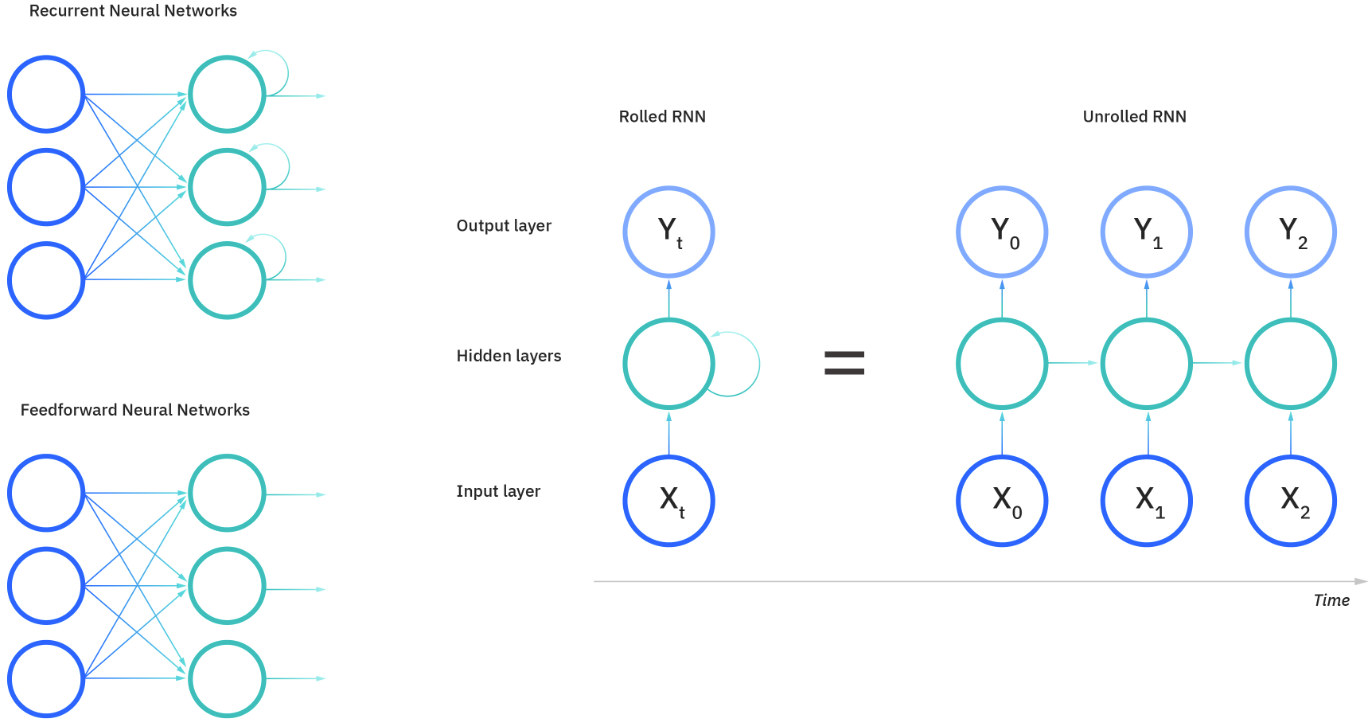

This way it can be seen that the initial neuron will recieve inputs $X_0$, and $h_0$ (commonly set to $0$); and produce outputs $Y_0$, and $h_1$. This step will then repeat with the new inputs $X_1$, and $h_1$, continuing until the end of the input sequence. Depending on the lengths of input an output sequences, 4 architecture types can be generated:

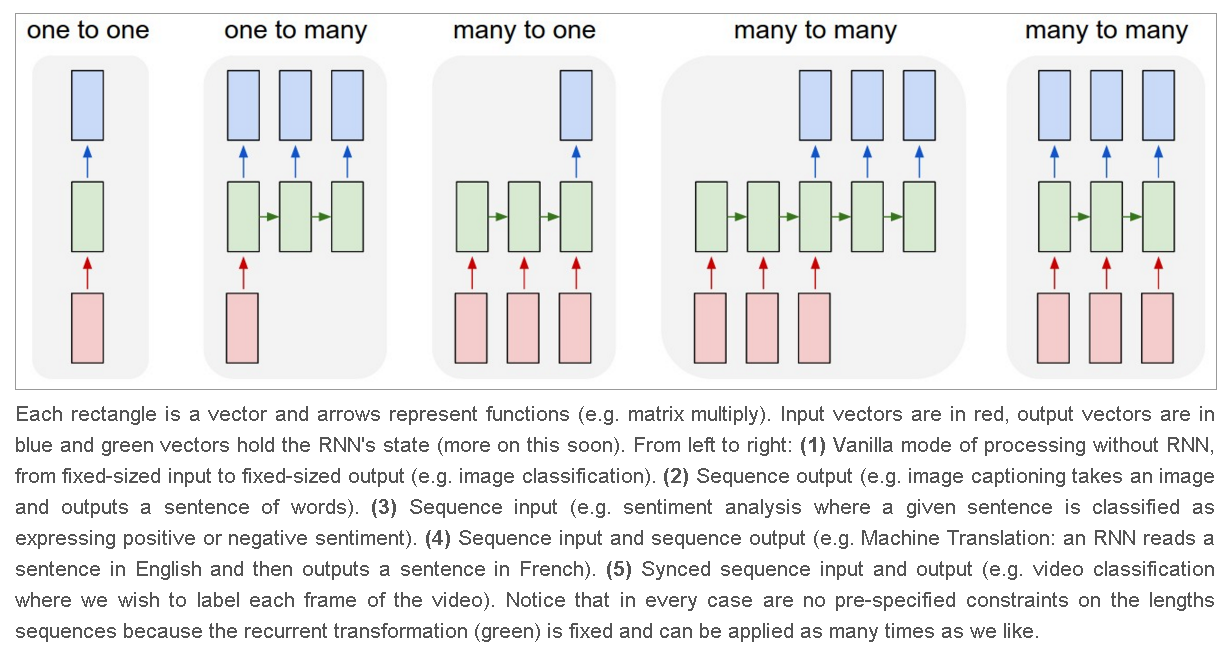

In [ ]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, num_classes): # network definition
        super().__init__()
        self.rnn1 = nn.RNN(
            input_size=1, 
            hidden_size=32, 
            num_layers=2, 
            batch_first=True)
        self.fc1 = nn.Linear(32,1)

    def forward(self, x): # forward pass
        # Reccurent layers expect input in the shape (batch_size, seq_length, num_features) and 
        # .view()/.squeeze() would need to occur to shape the data correctly
        h0 = torch.zeros(2, x.size(0), 32)
        out, _ = self.rnn1(x, h0)
        x = out[:, -1, :]
        x = self.fc1(x)
        return x

### Long Short-Term Memory (LSTM) Cell
The most complex of the three; it has short-term state $h$, long-term state $c$, and input $x$ which go through a *forget* (what to remove from long-term memory), *input* (what to save to long-term memory), and *output* (what to return at the current time step) gates before returning the outputs.

In [ ]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, num_classes): # network definition
        super().__init__()
        self.lstm1 = nn.LSTM(
            input_size=1, 
            hidden_size=32, 
            num_layers=2, 
            batch_first=True)
        self.fc1 = nn.Linear(32,1)

    def forward(self, x): # forward pass
        h0 = torch.zeros(2, x.size(0), 32)
        c0 = torch.zeros(2, x.size(0), 32)
        out, _ = self.lstm1(x, (h0, c0))
        x = out[:, -1, :]
        x = self.fc1(x)
        return x

### Gated Recurrent Unit (GRU) Cell
GRU cell is a simplified version of the LSTM cell, merging the log-term and short-term memories into a single hidden state (does not use *output* gate)

In [ ]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, num_classes): # network definition
        super().__init__()
        self.rnn1 = nn.GRU(
            input_size=1, 
            hidden_size=32, 
            num_layers=2, 
            batch_first=True)
        self.fc1 = nn.Linear(32,1)

    def forward(self, x): # forward pass
        h0 = torch.zeros(2, x.size(0), 32)
        out, _ = self.rnn1(x, h0)
        x = out[:, -1, :]
        x = self.fc1(x)
        return x

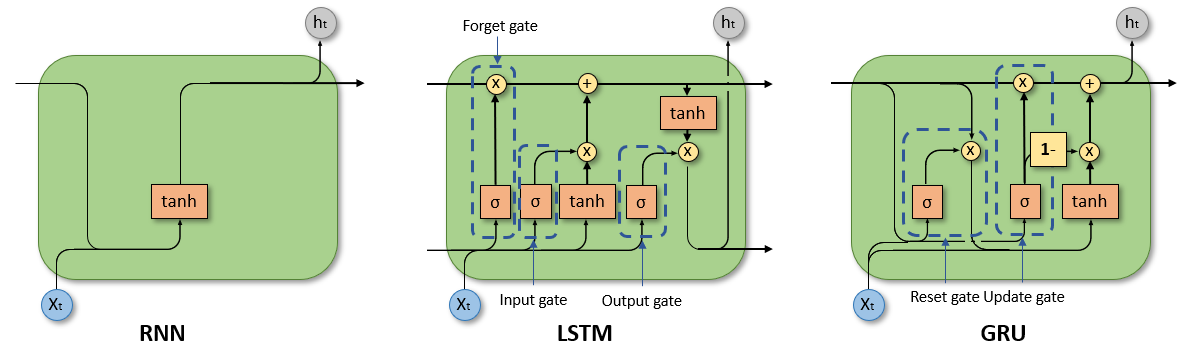

Note that RNNs are rarely used anymore due ot the better performances (short-term memory problem) of LSTM and GRU, and while their performance depends greatly on the task and data, it is worth noting that GRU calculations are simplier and easier than LSTM.

## Multi-Input Models
This model category instead of taking in a single input (vector, text, image, etc.), takes two (or more) augmented versions of the same input entity and learns the association across the version; thereby learning that they represent the same object (comparing passport photo with the photo taken at the airport).

In [99]:
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

class OmniglotDataset(Dataset):
    def __init__(self, path):
        super().__init__()

        # generate database if doesn't exist
        torchvision.datasets.Omniglot(root=path, download=True, transform=torchvision.transforms.ToTensor())

        self.transform = transforms.Compose([
            transforms.RandomRotation(20),
            transforms.RandomAutocontrast(),
            transforms.ToTensor(),
            transforms.Resize((64,64)),
        ])

        samples = []
        language_path = f'{path}/omniglot-py/images_background'
        languages = os.listdir(language_path)
        character_index = 0
        for index_i, language in enumerate(languages):
            characters = os.listdir(language_path + '/' + language)
            for index_j, character in enumerate(characters):
                for img_name in os.listdir(language_path + '/' + language + '/' + character):
                    img_path = f'{language_path}/{language}/{character}/{img_name}'
                    alph = torch.tensor([1 if index_i == i else 0 for i in range(0, len(languages))]).float()
                    label = torch.tensor([1 if character_index == i else 0 for i in range(0, 964)]).float()
                    samples.append((img_path, alph, label))
                character_index += 1
        self.samples = samples

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, indx):
        img_path, alph, label = self.samples[indx]
        img = Image.open(img_path).convert('L')
        tranformed_img = self.transform(img)
        return tranformed_img, alph, label
    
full_dataset = OmniglotDataset('./data')
train_dataset, test_dataset = random_split(full_dataset, [0.8, 0.2])

Files already downloaded and verified


In [100]:
import torch.nn as nn

class OmniglotNet(nn.Module):
    def __init__(self): # network definition
        super().__init__()
        self.image_layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(),
            nn.Flatten(),
            nn.Linear(32*32*32, 128),
            nn.ELU()
        )

        self.alphabet_layer = nn.Sequential(
            nn.Linear(30, 8),
            nn.ELU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(128+8, 964)
        )

    def forward(self, img, alph): # forward pass
        img = self.image_layer(img)
        alph = self.alphabet_layer(alph)
        x = torch.cat((img, alph), dim=1)
        x = self.classifier(x)
        return x

In [101]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

net = OmniglotNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
for epoch in range(100):
    pbar = tqdm(total=len(train_dataloader))
    for index, (image, alphabet, label) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = net(image, alphabet)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        pbar.update(1)
    pbar.close()
    print(loss.detach().numpy())

100%|██████████| 7712/7712 [02:31<00:00, 50.85it/s]


5.232645


100%|██████████| 7712/7712 [02:57<00:00, 43.38it/s]


4.846783


100%|██████████| 7712/7712 [02:59<00:00, 42.96it/s]


4.3379297


100%|██████████| 7712/7712 [02:58<00:00, 43.09it/s]


4.190216


100%|██████████| 7712/7712 [02:59<00:00, 42.91it/s]


1.3914704


100%|██████████| 7712/7712 [02:57<00:00, 43.46it/s]


1.236973


100%|██████████| 7712/7712 [02:56<00:00, 43.65it/s]


1.7224271


100%|██████████| 7712/7712 [02:57<00:00, 43.54it/s]


3.810229


100%|██████████| 7712/7712 [02:49<00:00, 45.48it/s]


1.0818009


100%|██████████| 7712/7712 [02:37<00:00, 49.10it/s]


0.3113151


100%|██████████| 7712/7712 [02:36<00:00, 49.16it/s]


0.9275359


100%|██████████| 7712/7712 [02:36<00:00, 49.28it/s]


1.2853519


100%|██████████| 7712/7712 [02:36<00:00, 49.31it/s]


0.012665535


100%|██████████| 7712/7712 [02:36<00:00, 49.33it/s]


0.06494755


100%|██████████| 7712/7712 [02:36<00:00, 49.38it/s]


0.010332233


100%|██████████| 7712/7712 [02:37<00:00, 48.91it/s]


0.9127464


100%|██████████| 7712/7712 [02:36<00:00, 49.42it/s]


0.06346945


100%|██████████| 7712/7712 [02:36<00:00, 49.35it/s]


0.47837853


100%|██████████| 7712/7712 [02:37<00:00, 48.89it/s]


0.031456053


100%|██████████| 7712/7712 [02:36<00:00, 49.18it/s]


1.0961651


100%|██████████| 7712/7712 [02:36<00:00, 49.35it/s]


0.13432671


100%|██████████| 7712/7712 [02:36<00:00, 49.22it/s]


0.13609658


100%|██████████| 7712/7712 [02:37<00:00, 48.90it/s]


0.0081731165


100%|██████████| 7712/7712 [02:37<00:00, 49.08it/s]


0.47301725


100%|██████████| 7712/7712 [02:36<00:00, 49.31it/s]


0.017042598


100%|██████████| 7712/7712 [02:36<00:00, 49.14it/s]


0.094597496


100%|██████████| 7712/7712 [02:35<00:00, 49.50it/s]


0.020657178


100%|██████████| 7712/7712 [02:36<00:00, 49.29it/s]


0.01815195


100%|██████████| 7712/7712 [02:37<00:00, 49.09it/s]


0.00037392648


100%|██████████| 7712/7712 [02:36<00:00, 49.28it/s]


0.01869637


100%|██████████| 7712/7712 [02:36<00:00, 49.15it/s]


0.006088178


100%|██████████| 7712/7712 [02:36<00:00, 49.16it/s]


0.0020641675


100%|██████████| 7712/7712 [02:37<00:00, 49.09it/s]


0.02056416


100%|██████████| 7712/7712 [02:36<00:00, 49.26it/s]


2.678362


100%|██████████| 7712/7712 [02:37<00:00, 49.04it/s]


0.018414145


100%|██████████| 7712/7712 [02:42<00:00, 47.34it/s]


0.0071342913


100%|██████████| 7712/7712 [02:49<00:00, 45.51it/s]


0.0099020405


100%|██████████| 7712/7712 [02:35<00:00, 49.56it/s]


0.006867965


100%|██████████| 7712/7712 [02:36<00:00, 49.21it/s]


0.0030657966


100%|██████████| 7712/7712 [02:38<00:00, 48.77it/s]


0.13655527


100%|██████████| 7712/7712 [02:36<00:00, 49.24it/s]


0.00037001382


100%|██████████| 7712/7712 [02:35<00:00, 49.48it/s]


0.00021531759


100%|██████████| 7712/7712 [02:34<00:00, 49.81it/s]


0.00015763163


100%|██████████| 7712/7712 [02:35<00:00, 49.59it/s]


0.00024600214


100%|██████████| 7712/7712 [02:36<00:00, 49.40it/s]


0.000770669


100%|██████████| 7712/7712 [02:36<00:00, 49.15it/s]


0.00072159676


100%|██████████| 7712/7712 [02:35<00:00, 49.57it/s]


0.0017981831


100%|██████████| 7712/7712 [02:37<00:00, 49.03it/s]


0.002712893


100%|██████████| 7712/7712 [02:35<00:00, 49.52it/s]


0.0027274163


100%|██████████| 7712/7712 [02:35<00:00, 49.53it/s]


0.0045540757


100%|██████████| 7712/7712 [02:35<00:00, 49.70it/s]


0.007054288


100%|██████████| 7712/7712 [02:36<00:00, 49.41it/s]


0.0017840269


100%|██████████| 7712/7712 [02:35<00:00, 49.68it/s]


0.006761581


100%|██████████| 7712/7712 [02:35<00:00, 49.72it/s]


0.024706947


100%|██████████| 7712/7712 [02:35<00:00, 49.64it/s]


0.0060644345


100%|██████████| 7712/7712 [02:35<00:00, 49.69it/s]


0.0011373814


100%|██████████| 7712/7712 [02:35<00:00, 49.66it/s]


0.35516867


100%|██████████| 7712/7712 [02:35<00:00, 49.59it/s]


0.014485655


100%|██████████| 7712/7712 [02:36<00:00, 49.39it/s]


0.0026074047


100%|██████████| 7712/7712 [02:37<00:00, 49.10it/s]


0.0002304645


100%|██████████| 7712/7712 [02:35<00:00, 49.67it/s]


0.00058371655


100%|██████████| 7712/7712 [02:37<00:00, 49.00it/s]


0.13926123


100%|██████████| 7712/7712 [02:36<00:00, 49.39it/s]


7.158094e-05


100%|██████████| 7712/7712 [02:35<00:00, 49.60it/s]


0.00048236712


100%|██████████| 7712/7712 [02:35<00:00, 49.52it/s]


0.0007837665


100%|██████████| 7712/7712 [02:35<00:00, 49.52it/s]


1.7165894e-05


100%|██████████| 7712/7712 [02:35<00:00, 49.65it/s]


0.000116692274


100%|██████████| 7712/7712 [02:36<00:00, 49.34it/s]


0.000287907


100%|██████████| 7712/7712 [02:36<00:00, 49.33it/s]


0.0058052633


100%|██████████| 7712/7712 [02:36<00:00, 49.35it/s]


0.0005395488


100%|██████████| 7712/7712 [02:36<00:00, 49.31it/s]


0.0030509545


100%|██████████| 7712/7712 [02:35<00:00, 49.62it/s]


2.413959e-05


100%|██████████| 7712/7712 [02:35<00:00, 49.53it/s]


0.0016874678


100%|██████████| 7712/7712 [02:35<00:00, 49.60it/s]


0.11943494


100%|██████████| 7712/7712 [02:35<00:00, 49.56it/s]


0.0009523101


100%|██████████| 7712/7712 [02:35<00:00, 49.61it/s]


0.00458543


100%|██████████| 7712/7712 [02:36<00:00, 49.13it/s]


0.011399997


100%|██████████| 7712/7712 [02:35<00:00, 49.49it/s]


0.0012509355


100%|██████████| 7712/7712 [02:36<00:00, 49.38it/s]


4.4701537e-05


100%|██████████| 7712/7712 [02:35<00:00, 49.62it/s]


0.0038047773


100%|██████████| 7712/7712 [02:35<00:00, 49.48it/s]


0.0055476916


100%|██████████| 7712/7712 [02:35<00:00, 49.59it/s]


1.5854614e-05


100%|██████████| 7712/7712 [02:36<00:00, 49.38it/s]


0.0051670065


100%|██████████| 7712/7712 [02:35<00:00, 49.46it/s]


0.00010006877


100%|██████████| 7712/7712 [02:36<00:00, 49.22it/s]


0.00011889722


100%|██████████| 7712/7712 [02:38<00:00, 48.79it/s]


0.000115325834


100%|██████████| 7712/7712 [02:36<00:00, 49.15it/s]


0.00011913694


100%|██████████| 7712/7712 [02:35<00:00, 49.56it/s]


6.7949e-06


100%|██████████| 7712/7712 [02:35<00:00, 49.64it/s]


0.08273271


100%|██████████| 7712/7712 [02:35<00:00, 49.47it/s]


0.00023641693


100%|██████████| 7712/7712 [02:35<00:00, 49.68it/s]


8.3082e-05


100%|██████████| 7712/7712 [02:36<00:00, 49.43it/s]


0.020410191


100%|██████████| 7712/7712 [02:35<00:00, 49.44it/s]


0.0017051927


100%|██████████| 7712/7712 [02:36<00:00, 49.35it/s]


0.000522824


100%|██████████| 7712/7712 [02:36<00:00, 49.18it/s]


0.009271688


100%|██████████| 7712/7712 [02:36<00:00, 49.41it/s]


0.00024294913


100%|██████████| 7712/7712 [02:35<00:00, 49.52it/s]


0.014428613


100%|██████████| 7712/7712 [02:36<00:00, 49.24it/s]


0.005266007


100%|██████████| 7712/7712 [02:36<00:00, 49.36it/s]


3.4927412e-05


100%|██████████| 7712/7712 [02:36<00:00, 49.28it/s]

0.002321302
